<a href="https://colab.research.google.com/github/ArtyomShabunin/SMOPA/blob/main/lesson_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://prana-system.com/files/110/rds_color_full.png" alt="tot image" width="300"  align="center"/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://mpei.ru/AboutUniverse/OficialInfo/Attributes/PublishingImages/logo1.jpg" alt="mpei image" width="200" align="center"/>
<img src="https://mpei.ru/Structure/Universe/tanpe/structure/tfhe/PublishingImages/tot.png" alt="tot image" width="100"  align="center"/>

---

# **Системы машинного обучения и предиктивной аналитики в тепловой и возобновляемой энергетике**  

# ***Практические занятия***


---

# Занятие №7
# Многоклассовая классификация методами глубокого обучения
**2 апреля 2025г.**

In [425]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
# from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, r2_score


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from imblearn.under_sampling import RandomUnderSampler

from tqdm import tqdm

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
device

device(type='cuda')

## Загрузка данных

In [ ]:
import gdown
import warnings
warnings.filterwarnings('ignore')
gdown.download('https://drive.google.com/uc?id=1j54o4pHTm3HvaYTEtv_i4hOJGy5yNeZZ', verify=False)

data = pd.read_parquet("./data_modes.gzip")

Downloading...
From (original): https://drive.google.com/uc?id=1j54o4pHTm3HvaYTEtv_i4hOJGy5yNeZZ
From (redirected): https://drive.google.com/uc?id=1j54o4pHTm3HvaYTEtv_i4hOJGy5yNeZZ&confirm=t&uuid=883bb37e-5b44-49be-b7c6-1702d2dc2f9d
To: /content/data_modes.gzip
100%|██████████| 173M/173M [00:01<00:00, 138MB/s] 


In [ ]:
data.shape

(1082098, 56)

In [ ]:
data.head()

,GTA1.DBinPU.Aldi,GTA1.DBinPU.Alvna,GTA1.DBinPU.Alzzo,GTA1.DBinPU.Bo,GTA1.DBinPU.DlPkf,GTA1.DBinPU.DlPtgft,GTA1.DBinPU.DlPvf,GTA1.DBinPU.fi,GTA1.DBinPU.hmGTD,GTA1.DBinPU.hmTG,...,heated_air,zzo_is_open,full_power_mode,partial_power_mode,increas_power_mode,decreas_power_mode,start_up_mode,shutdown_mode,stopped_state_mode,air_heating_mode
2023-02-26 06:59:50,225.550000,-4.398000,-0.082000,101.044,113.088000,33.709000,0.200000,56.615000,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:00,225.610769,-4.327115,-0.089769,101.044,113.151231,33.709000,0.200000,56.615000,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:10,225.436897,-4.363724,-0.091000,101.044,113.039759,33.633586,0.200207,56.516103,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:20,225.710833,-4.306625,-0.093000,101.044,113.053458,33.506500,0.200750,56.376000,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False
2023-02-26 07:00:30,226.355000,-4.183118,-0.091500,101.044,113.730941,33.818529,0.200000,56.199353,442.64,444.536,...,False,False,True,False,False,False,False,False,False,False


## Сформируем датасет для решения задачи многоклассовой классификации

Выберем сигналы которые будем использовать. Исключим все признаки на основании которых выделялись целевые режимы.

In [ ]:
feature_columns = [
    'GTA1.DBinPU.Alzzo', 'GTA1.DBinPU.Bo', 'GTA1.DBinPU.DlPkf',
    'GTA1.DBinPU.DlPtgft', 'GTA1.DBinPU.DlPvf', 'GTA1.DBinPU.fi',
    'GTA1.DBinPU.hmGTD', 'GTA1.DBinPU.hmTG', 'GTA1.DBinPU.P1mvhTG',
    'GTA1.DBinPU.Pk',
    'GTA1.DBinPU.Pmvh', 'GTA1.DBinPU.PmvhMOGTD',
    'GTA1.DBinPU.PmvhMOTG', 'GTA1.DBinPU.PmvyhMOGTD',
    'GTA1.DBinPU.PmvyhMOTG', 'GTA1.DBinPU.Prazrjag_navhode',
    'GTA1.DBinPU.Ptgpd', 'GTA1.DBinPU.Ptgvh',
    'GTA1.DBinPU.Pvh',
    'GTA1.DBinPU.Pvyhlg',
    'GTA1.DBinPU.Qtg',
    'GTA1.DBinPU.Tk',
    'GTA1.DBinPU.Tn', 'GTA1.DBinPU.Tt', 'GTA1.DBinPU.Tvh1',
    'GTA1.DBinPU.Pzad'
    ]

target_columns = [
    'full_power_mode',
    'partial_power_mode',
    'increas_power_mode',
    'decreas_power_mode',
    'start_up_mode',
    'shutdown_mode',
    'stopped_state_mode'
]

In [ ]:
data.loc[data['adjustment_range'], ['start_up_mode']] = False
data.loc[data['adjustment_range'], ['shutdown_mode']] = False
data.loc[data['increase_power'], ['shutdown_mode']] = False
data.loc[data['decreas_power_mode'], ['start_up_mode']] = False

In [ ]:
data = data.loc[data[target_columns].sum(axis=1) == 1]

In [ ]:
X = data.loc[:,feature_columns]

In [ ]:
data['target'] = data[target_columns].idxmax(axis=1)
y = data.loc[:, ['target']]

In [ ]:
y.value_counts()

,count
target,
full_power_mode,1044257
stopped_state_mode,26614
partial_power_mode,9547
shutdown_mode,344
increas_power_mode,109
decreas_power_mode,103
start_up_mode,98


### Деление на тестовую и тренировочную выборки

In [ ]:
from sklearn.model_selection import train_test_split
# Разделяем с учетом дисбаланса классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
y_train.value_counts()

,count
target,
full_power_mode,835405
stopped_state_mode,21291
partial_power_mode,7638
shutdown_mode,275
increas_power_mode,87
decreas_power_mode,82
start_up_mode,79


In [ ]:
y_test.value_counts()

,count
target,
full_power_mode,208852
stopped_state_mode,5323
partial_power_mode,1909
shutdown_mode,69
increas_power_mode,22
decreas_power_mode,21
start_up_mode,19


Видно, что датасет сильно несбалансирован.
При такой несбалансорованности модели будут плохо обучаеться на редких классах.
Алгоритм может игнорировать малочисленные классы, потому что минимизация ошибки будет достигаться за счет предсказания большинства.
Например, если модель всегда предсказывает full_power_mode, она все равно получит высокую точность.

### Балансировка данных
**Oversampling (увеличение малых классов)**  
   - Повторение существующих редких примеров или их генерация.  
   - **SMOTE (Synthetic Minority Over-sampling Technique)** – создает новые точки малочисленных классов, используя линейные комбинации соседних точек.  

**Undersampling (уменьшение частых классов)**  
- Удаление случайных примеров из большинства классов.  

**Комбинация Oversampling + Undersampling**  
   - Часто лучше сначала **уменьшить большие**, а затем **увеличить малые классы**.  

#### Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
sampling_strategy = {
    "full_power_mode": 1000,
    "stopped_state_mode": 1000,
    "partial_power_mode": 1000
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
y_train_resampled.value_counts()

,count
target,
full_power_mode,1000
stopped_state_mode,1000
partial_power_mode,1000
shutdown_mode,275
increas_power_mode,87
decreas_power_mode,82
start_up_mode,79


In [ ]:
sampling_strategy = {
    "full_power_mode": 100,
    "stopped_state_mode": 100,
    "partial_power_mode": 100
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_test_resampled, y_test_resampled = rus.fit_resample(X_test, y_test)

In [ ]:
y_test_resampled.value_counts()

,count
target,
full_power_mode,100
stopped_state_mode,100
partial_power_mode,100
shutdown_mode,69
increas_power_mode,22
decreas_power_mode,21
start_up_mode,19


#### Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_resampled, y_train_resampled)

In [ ]:
y_train_resampled.value_counts()

,count
target,
decreas_power_mode,1000
full_power_mode,1000
increas_power_mode,1000
partial_power_mode,1000
shutdown_mode,1000
start_up_mode,1000
stopped_state_mode,1000


### Нормализация или стандартизация данных

In [ ]:
# scaler = preprocessing.MinMaxScaler() # нормализация данных
scaler = preprocessing.StandardScaler() # стандартизация данных

X_train_resampled_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_resampled),
    columns=X_train_resampled.columns,
    index=X_train_resampled.index)

X_test_resampled_scaled = pd.DataFrame(
    scaler.transform(X_test_resampled),
    columns=X_test_resampled.columns,
    index=X_test_resampled.index)

X_train_resampled_scaled.describe()

,GTA1.DBinPU.Alzzo,GTA1.DBinPU.Bo,GTA1.DBinPU.DlPkf,GTA1.DBinPU.DlPtgft,GTA1.DBinPU.DlPvf,GTA1.DBinPU.fi,GTA1.DBinPU.hmGTD,GTA1.DBinPU.hmTG,GTA1.DBinPU.P1mvhTG,GTA1.DBinPU.Pk,...,GTA1.DBinPU.Ptgpd,GTA1.DBinPU.Ptgvh,GTA1.DBinPU.Pvh,GTA1.DBinPU.Pvyhlg,GTA1.DBinPU.Qtg,GTA1.DBinPU.Tk,GTA1.DBinPU.Tn,GTA1.DBinPU.Tt,GTA1.DBinPU.Tvh1,GTA1.DBinPU.Pzad
count,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,...,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03
mean,-8.120488e-18,1.868930e-14,6.496391e-17,-9.744586e-17,-6.496391e-17,8.120488e-17,-4.872293e-16,6.861813e-16,-1.624098e-17,-6.496391e-17,...,6.496391e-17,1.461688e-16,-7.795669e-16,6.496391e-17,1.299278e-16,-6.496391e-17,3.248195e-17,-1.624098e-16,-6.090366e-18,-1.299278e-16
std,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,...,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-1.507644e-01,-3.459538e+00,-1.359193e+00,-1.251625e+00,-1.306516e+00,-1.731105e+00,-1.680412e+00,-1.865194e+00,-2.451840e+00,-1.271887e+00,...,-1.729158e+00,-1.748365e+00,-2.031793e+00,-1.083613e+00,-1.277763e+00,-1.455763e+00,-3.253751e+00,-1.776869e+00,-3.356988e+00,-1.127810e+00
25%,-1.391758e-01,-8.307980e-01,-1.262726e+00,-1.095186e+00,-1.162293e+00,-7.558173e-01,-7.088812e-01,-7.444614e-01,1.537422e-01,-1.239029e+00,...,-7.406215e-01,1.373285e-01,-1.035686e+00,-9.823339e-01,-1.272594e+00,-1.234723e+00,-7.522978e-01,-5.764278e-01,-6.373436e-01,-1.127810e+00
50%,-1.368433e-01,1.710868e-01,3.483803e-02,-7.633305e-02,1.986922e-01,-1.749946e-01,-1.143499e-01,-4.277733e-02,4.172262e-01,3.958619e-01,...,5.192383e-01,5.433260e-01,9.823599e-03,-2.771661e-01,2.650629e-01,5.097694e-01,-9.010739e-02,4.206206e-01,-9.236345e-02,1.801335e-01
75%,-1.332264e-01,6.949562e-01,8.878110e-01,9.992970e-01,9.366536e-01,7.104108e-01,7.995305e-01,6.311594e-01,5.249668e-01,1.015378e+00,...,6.446625e-01,6.130851e-01,9.630707e-01,1.074692e+00,9.475534e-01,8.809097e-01,6.832552e-01,6.771500e-01,8.444856e-01,1.129646e+00
max,7.499191e+00,2.774366e+00,1.808819e+00,1.830728e+00,1.605236e+00,2.593301e+00,2.581322e+00,2.436444e+00,9.898869e-01,1.162595e+00,...,7.783163e-01,7.485159e-01,1.337513e+00,1.729531e+00,1.498963e+00,1.265786e+00,2.449844e+00,1.156022e+00,2.414970e+00,1.209713e+00


### Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [ ]:
y_train_resampled_encoded = encoder.fit_transform(y_train_resampled.values[:,0])
y_test_resampled_encoded = encoder.transform(y_test_resampled.values[:,0])

## Полносвязная нейронная сеть (многослойный персептрон)

Инициализируем переменные для дальнейшего сравнения моделей

In [ ]:
accuracy_classifier = {}
precision_classifier = {}
recall_classifier = {}
f1_classifier = {}

### Dataset

In [ ]:
class ModeDataset(Dataset):
    def __init__(self):
        self.x = torch.tensor(X_train_resampled_scaled.values, dtype=torch.float32)
        self.y = torch.tensor(y_train_resampled_encoded, dtype=torch.long)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]

In [ ]:
dataset = ModeDataset()

print(len(dataset))
print("Sample number 0 : ", dataset[0])
print(dataset[0][0], dataset[0][1])

7000
Sample number 0 :  (tensor([-0.1404,  0.6971,  0.4125,  0.2917,  0.4387, -0.9233, -1.6643, -1.8603,
         0.2377,  0.6582,  0.6295, -0.6811,  0.3844,  0.0000,  0.0000,  0.5016,
         0.5942,  0.5822, -0.3299,  0.6691,  0.6938,  0.6862, -0.1369,  0.3901,
        -0.3336,  0.3548]), tensor(0))
tensor([-0.1404,  0.6971,  0.4125,  0.2917,  0.4387, -0.9233, -1.6643, -1.8603,
         0.2377,  0.6582,  0.6295, -0.6811,  0.3844,  0.0000,  0.0000,  0.5016,
         0.5942,  0.5822, -0.3299,  0.6691,  0.6938,  0.6862, -0.1369,  0.3901,
        -0.3336,  0.3548]) tensor(0)


In [ ]:
BATCH_SIZE = 256

INPUT_SIZE = len(feature_columns)
OUTPUT_SIZE = len(target_columns)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Функция для обучения модели

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):

    loaders = {"train": train_loader, "valid": valid_loader}

    epochs = num_epochs

    lr = []
    losses = {"train": [], "valid": []}
    for epoch in tqdm(range(epochs)):

        for k, dataloader in loaders.items():
            running_loss = []

            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                loss = criterion(outp, y_batch)
                running_loss.append(loss.item())

                if k == "train":
                    loss.backward()
                    optimizer.step()

            if k == "train":
                lr.append(scheduler.optimizer.param_groups[0]['lr'])
            losses[k].append(np.array(running_loss).mean())

        scheduler.step(losses["train"][-1])

    return model, losses, lr

### Архитектура нейронной сети

#### Модель №1


In [ ]:
class FCNN_v1(nn.Module):
  def __init__(
      self, hidden_size=512, hidden_num=1,
      # dropout_rate=0
      ):
    super(FCNN_v1, self).__init__()

    # Входной слой
    self.input_layer = nn.Sequential(
        nn.Linear(INPUT_SIZE, hidden_size),
        # nn.BatchNorm1d(hidden_size),
        nn.ReLU(),
        # nn.Dropout(dropout_rate)
    )

    # Скрытые слои
    self.hidden_layers = nn.ModuleList()
    for _ in range(hidden_num):
        self.hidden_layers.append(
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                # nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                # nn.Dropout(dropout_rate)
            )
        )

    # Выходной слой
    self.output_layer = nn.Linear(hidden_size, OUTPUT_SIZE)

  def forward(self, x):
    x = self.input_layer(x)

    for layer in self.hidden_layers:
        x = layer(x)

    x = self.output_layer(x)
    return x


##### Обучение модели

In [ ]:
FCNN_v1_16_2 = FCNN_v1(16, 2).to(device)
# FCNN_64_2._initialize_weights()

# criterion = nn.MSELoss()

# class_weights = torch.tensor([2.0, 2.0, 1.0]).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(FCNN_v1_16_2.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=30, threshold=0.0001)

FCNN_v1_16_2, losses_FCNN_v1_16_2, lr_FCNN_v1_16_2 = train_model(
    FCNN_v1_16_2, criterion, optimizer,
    scheduler, num_epochs=200)

100%|██████████| 200/200 [00:18<00:00, 10.76it/s]


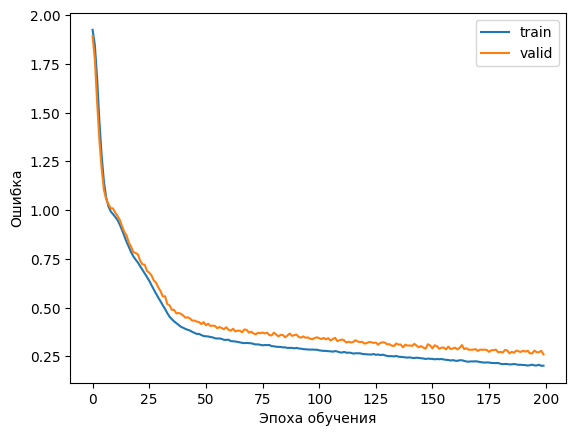

In [ ]:
plt.plot(losses_FCNN_v1_16_2['train'], label='train');
plt.plot(losses_FCNN_v1_16_2['valid'], label='valid');
plt.legend();
plt.ylabel("Ошибка");
plt.xlabel("Эпоха обучения");

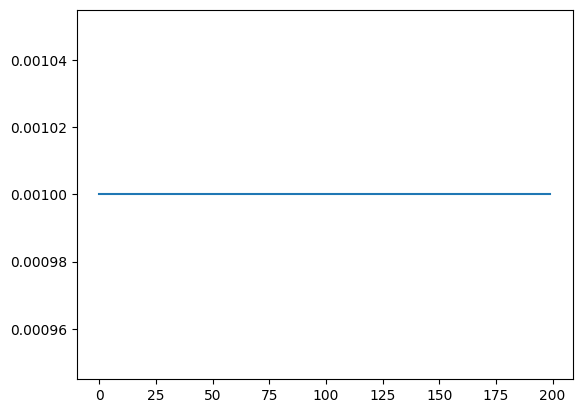

In [ ]:
plt.plot(lr_FCNN_v1_16_2);

In [ ]:
print('Loss в конце обучения')
print(f'На обучающей выборке: {losses_FCNN_v1_16_2["train"][-1]:.5f}')
print(f'На валидационной выборке: {losses_FCNN_v1_16_2["valid"][-1]:.5f}')

Loss в конце обучения
На обучающей выборке: 0.20291
На валидационной выборке: 0.26072


In [ ]:
some_indexes = y_test_resampled.groupby('target').sample(n=1, random_state=42).index
X_some_modes = X_test_resampled_scaled.loc[some_indexes]
y_some_modes = y_test_resampled.loc[some_indexes]

FCNN_v1_16_2.to("cpu")
FCNN_v1_16_2.eval()
logits = FCNN_v1_16_2(torch.tensor(X_some_modes.values, dtype=torch.float32))
predicted_classes = torch.argmax(logits, dim=1)

for target, predict in zip(y_some_modes.values, predicted_classes.detach().numpy()):
    print(f"Истина - {target[0]} >>> {encoder.inverse_transform([predict])[0]} - предсказание")

Истина - decreas_power_mode >>> decreas_power_mode - предсказание
Истина - full_power_mode >>> full_power_mode - предсказание
Истина - increas_power_mode >>> partial_power_mode - предсказание
Истина - partial_power_mode >>> partial_power_mode - предсказание
Истина - shutdown_mode >>> start_up_mode - предсказание
Истина - start_up_mode >>> start_up_mode - предсказание
Истина - stopped_state_mode >>> stopped_state_mode - предсказание


In [ ]:
logits

tensor([[ 6.6515e+00,  6.5285e+00, -4.8745e-01, -1.7350e+00, -1.0860e+01,
         -1.1072e+01, -1.8317e+01],
        [ 3.5279e+00,  4.6797e+00, -2.7023e-02, -2.8484e+00, -8.9708e+00,
         -6.7265e+00, -1.9143e+01],
        [ 1.9796e+00, -3.9009e+00,  2.2586e+00,  3.5417e+00, -8.3861e+00,
         -8.0056e+00, -1.1949e+01],
        [ 2.9847e-01,  1.2397e-01, -1.5405e+00,  7.2803e+00, -7.7859e+00,
         -9.9176e+00, -9.2303e+00],
        [-2.4504e+01, -2.6106e+01, -2.6990e+01, -1.7893e+01,  1.0717e+01,
          1.1608e+01, -6.8327e+00],
        [-2.1989e+01, -2.9144e+01, -2.4108e+01, -1.3332e+01,  1.0197e+01,
          1.0674e+01, -2.3645e+00],
        [-1.7501e+00, -2.5855e+01, -5.0251e+01,  5.0194e+00,  7.5210e+00,
         -8.7894e+00,  1.8900e+01]], grad_fn=<AddmmBackward0>)

In [ ]:
encoder.transform(y_some_modes.values)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
criterion(logits, torch.tensor(encoder.transform(y_some_modes.values)))

tensor(0.6165, grad_fn=<NllLossBackward0>)

In [ ]:
torch.softmax(logits, dim=1)

tensor([[5.3043e-01, 4.6903e-01, 4.2095e-04, 1.2090e-04, 1.3166e-08, 1.0650e-08,
         7.6030e-12],
        [2.3844e-01, 7.5433e-01, 6.8152e-03, 4.0566e-04, 8.8973e-07, 8.3935e-06,
         3.4018e-11],
        [1.4097e-01, 3.9381e-04, 1.8633e-01, 6.7229e-01, 4.4399e-06, 6.4958e-06,
         1.2587e-07],
        [9.2687e-04, 7.7846e-04, 1.4736e-04, 9.9815e-01, 2.8578e-07, 3.3903e-08,
         6.7407e-08],
        [1.4694e-16, 2.9622e-17, 1.2240e-17, 1.0922e-13, 2.9090e-01, 7.0910e-01,
         6.9476e-09],
        [4.0267e-15, 3.1435e-18, 4.8382e-16, 2.3158e-11, 3.8302e-01, 6.1698e-01,
         1.3421e-06],
        [1.0757e-09, 3.6568e-20, 9.2940e-31, 9.3677e-07, 1.1432e-05, 9.4314e-13,
         9.9999e-01]], grad_fn=<SoftmaxBackward0>)

### Анализ качества модели

In [ ]:
FCNN_v1_16_2.eval()
logits =  FCNN_v1_16_2(torch.tensor(X_test_resampled_scaled.values, dtype=torch.float32))

probabilities = torch.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

y_test_pred_FCNN_v1_16_2 = encoder.inverse_transform(predicted_classes)

#### Матрица неточностей

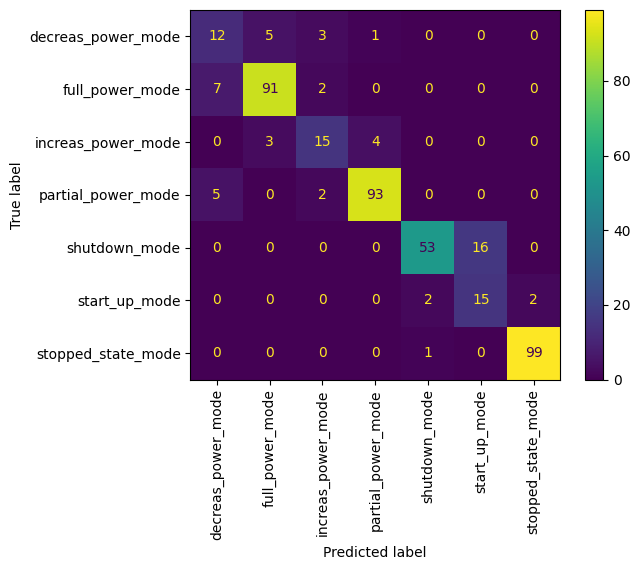

In [ ]:
conf_mat = confusion_matrix(y_test_resampled, y_test_pred_FCNN_v1_16_2)
ConfusionMatrixDisplay(conf_mat, display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()

#### Accuracy

In [426]:
accuracy_classifier['FCNN_v1_16_2'] = accuracy_score(y_test_resampled, y_test_pred_FCNN_v1_16_2)

#### Precision и recall

In [427]:
precision_classifier['FCNN_v1_16_2'] = precision_score(y_test_resampled, y_test_pred_FCNN_v1_16_2, average='macro', zero_division = np.nan)
recall_classifier['FCNN_v1_16_2'] = recall_score(y_test_resampled, y_test_pred_FCNN_v1_16_2, average='macro', zero_division = np.nan)

#### F1

In [429]:
f1_classifier['FCNN_v1_16_2'] = f1_score(y_test_resampled, y_test_pred_FCNN_v1_16_2, average='macro', zero_division = np.nan)

#### Значения метрик

In [430]:
print(f"accuracy - {accuracy_classifier['FCNN_v1_16_2']*100:0.2f}%")
print(f"precision - {precision_classifier['FCNN_v1_16_2']*100:0.2f}%")
print(f"recall - {recall_classifier['FCNN_v1_16_2']*100:0.2f}%")
print(f"F1 - {f1_classifier['FCNN_v1_16_2']*100:0.2f}%")

accuracy - 87.70%
precision - 78.01%
recall - 80.58%
F1 - 78.60%


#### Модель №2
#### Обучение модели

In [434]:
FCNN_v1_16_4 = FCNN_v1(16, 4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(FCNN_v1_16_4.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=30, threshold=0.0001)

FCNN_v1_16_4, losses_FCNN_v1_16_4, lr_FCNN_v1_16_4 = train_model(
    FCNN_v1_16_4, criterion, optimizer,
    scheduler, num_epochs=200)

100%|██████████| 200/200 [00:21<00:00,  9.50it/s]


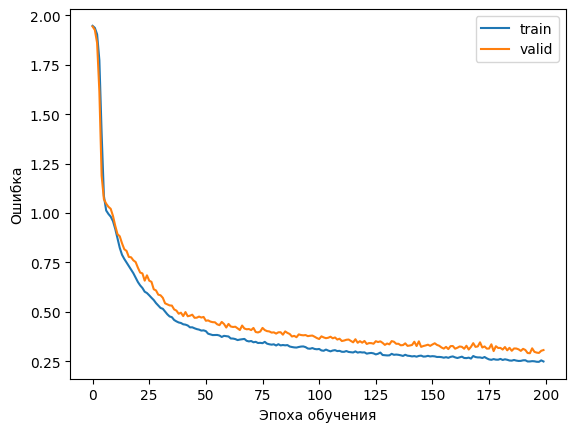

In [435]:
plt.plot(losses_FCNN_v1_16_4['train'], label='train');
plt.plot(losses_FCNN_v1_16_4['valid'], label='valid');
plt.legend();
plt.ylabel("Ошибка");
plt.xlabel("Эпоха обучения");

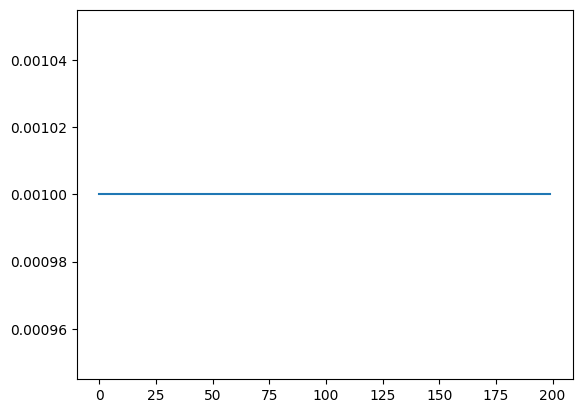

In [436]:
plt.plot(lr_FCNN_v1_16_4);

In [437]:
print('Loss в конце обучения')
print(f'На обучающей выборке: {losses_FCNN_v1_16_4["train"][-1]:.5f}')
print(f'На валидационной выборке: {losses_FCNN_v1_16_4["valid"][-1]:.5f}')

Loss в конце обучения
На обучающей выборке: 0.24788
На валидационной выборке: 0.30556


In [438]:
some_indexes = y_test_resampled.groupby('target').sample(n=1, random_state=42).index
X_some_modes = X_test_resampled_scaled.loc[some_indexes]
y_some_modes = y_test_resampled.loc[some_indexes]

FCNN_v1_16_4.to("cpu")
FCNN_v1_16_4.eval()
logits = FCNN_v1_16_4(torch.tensor(X_some_modes.values, dtype=torch.float32))
predicted_classes = torch.argmax(logits, dim=1)

for target, predict in zip(y_some_modes.values, predicted_classes.detach().numpy()):
    print(f"Истина - {target[0]} >>> {encoder.inverse_transform([predict])[0]} - предсказание")

Истина - decreas_power_mode >>> full_power_mode - предсказание
Истина - full_power_mode >>> full_power_mode - предсказание
Истина - increas_power_mode >>> increas_power_mode - предсказание
Истина - partial_power_mode >>> partial_power_mode - предсказание
Истина - shutdown_mode >>> start_up_mode - предсказание
Истина - start_up_mode >>> start_up_mode - предсказание
Истина - stopped_state_mode >>> stopped_state_mode - предсказание


### Анализ качества модели

In [439]:
FCNN_v1_16_4.eval()
logits =  FCNN_v1_16_4(torch.tensor(X_test_resampled_scaled.values, dtype=torch.float32))

probabilities = torch.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

y_test_pred_FCNN_v1_16_4 = encoder.inverse_transform(predicted_classes)

#### Матрица неточностей

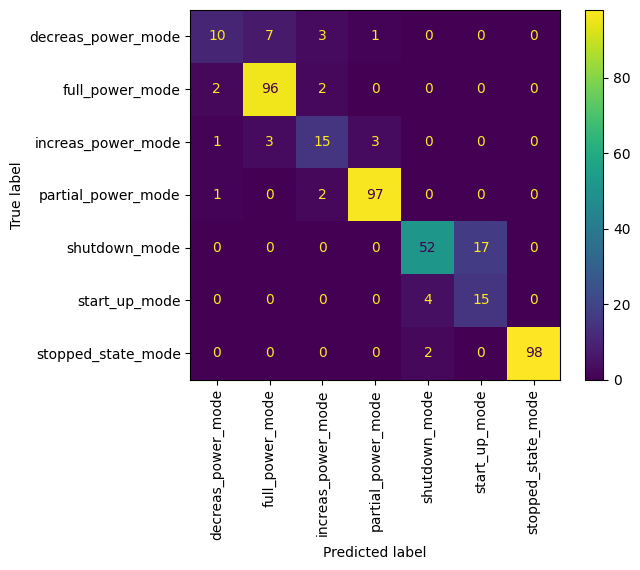

In [440]:
conf_mat = confusion_matrix(y_test_resampled, y_test_pred_FCNN_v1_16_4)
ConfusionMatrixDisplay(conf_mat, display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()

#### Accuracy

In [441]:
accuracy_classifier['FCNN_v1_16_4'] = accuracy_score(y_test_resampled, y_test_pred_FCNN_v1_16_4)

#### Precision и recall

In [442]:
precision_classifier['FCNN_v1_16_4'] = precision_score(y_test_resampled, y_test_pred_FCNN_v1_16_4, average='macro', zero_division = np.nan)
recall_classifier['FCNN_v1_16_4'] = recall_score(y_test_resampled, y_test_pred_FCNN_v1_16_4, average='macro', zero_division = np.nan)

#### F1

In [443]:
f1_classifier['FCNN_v1_16_4'] = f1_score(y_test_resampled, y_test_pred_FCNN_v1_16_4, average='macro', zero_division = np.nan)

#### Значения метрик

In [444]:
print(f"accuracy - {accuracy_classifier['FCNN_v1_16_4']*100:0.2f}%")
print(f"precision - {precision_classifier['FCNN_v1_16_4']*100:0.2f}%")
print(f"recall - {recall_classifier['FCNN_v1_16_4']*100:0.2f}%")
print(f"F1 - {f1_classifier['FCNN_v1_16_4']*100:0.2f}%")

accuracy - 88.86%
precision - 80.39%
recall - 80.16%
F1 - 79.25%


In [445]:
f1_classifier

{'FCNN_v1_16_2': 0.7860275636761048, 'FCNN_v1_16_4': 0.7924988056233365}

In [ ]:
FCNN_64_5 = FCNN(26, 7, 64, 5)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(FCNN_64_5.parameters(), lr=1e-3)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

FCNN_64_5, losses_FCNN_64_5 = train_model(
    FCNN_64_5, criterion, optimizer,
    scheduler, num_epochs=100)

100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


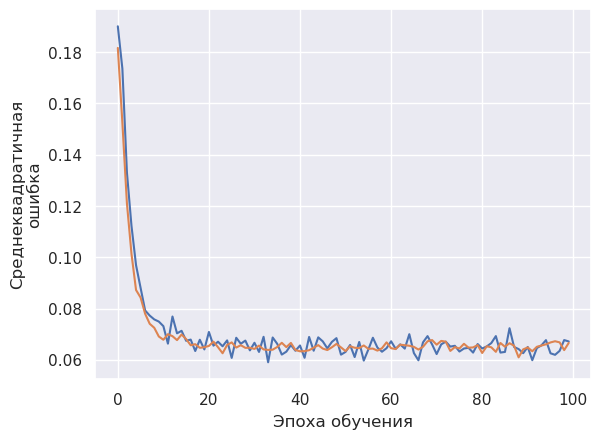

In [ ]:
plt.plot(losses_FCNN_64_5['train'], label='train');
plt.plot(losses_FCNN_64_5['valid'], label='valid');
plt.ylabel("Среднеквадратичная\nошибка");
plt.xlabel("Эпоха обучения");

In [ ]:
FCNN_256_2 = FCNN(26, 7, 256, 2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(FCNN_256_2.parameters(), lr=1e-3)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

FCNN_256_2, losses_FCNN_256_2 = train_model(
    FCNN_256_2, criterion, optimizer,
    scheduler, num_epochs=100)

100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


In [ ]:
plt.plot(losses_FCNN_256_2['train'], label='train');
plt.plot(losses_FCNN_256_2['valid'], label='valid');
plt.ylabel("Среднеквадратичная\nошибка");
plt.xlabel("Эпоха обучения");
plt.legend();

NameError: name 'losses_FCNN_256_2' is not defined

In [ ]:
# y_test_pred = cross_val_predict(FCNN_256_2, torch.tensor(X_test, dtype=torch.float32), y_test, cv=3)
# conf_mx = confusion_matrix(y_test, y_train_pred)
# conf_mx

array([[-0.21138504,  0.55662423, -0.35919895, ...,  0.38173824,
         0.92805023, -0.39852083],
       [-0.21380329, -0.50087478,  0.92281509, ...,  0.75502602,
         1.03233705,  0.97874579],
       [ 1.91535401,  0.55583456,  0.84823309, ...,  0.50466226,
        -1.60257995,  0.97874579],
       ...,
       [-0.2194112 ,  0.409426  ,  0.11006636, ...,  0.24972722,
        -1.21506219,  0.15773938],
       [-0.21823864,  1.35595022,  0.61681358, ...,  0.41620173,
        -0.71802525,  0.69028408],
       [-0.2203578 ,  0.5435486 ,  0.5195617 , ...,  0.46310713,
        -0.98825485,  0.97874579]])

In [ ]:
y_train_pred = FCNN_256_2(torch.tensor(scaler.transform(X_test), dtype=torch.float32)).detach().numpy()

In [ ]:
y_test = torch.tensor(y_test, dtype=torch.float32).detach().numpy()

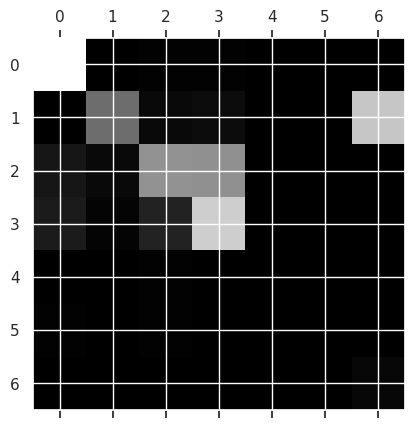

In [ ]:
conf_mx = confusion_matrix(y_test.argmax(axis=1), y_train_pred.argmax(axis=1))
conf_mx
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
!pip install shap

import shap

explainer = shap.Explainer(lambda x: FCNN_64_2(torch.tensor(x.values, dtype=torch.float32)), X_train_resampled_scaled)
shap_values = explainer(X_test_resampled_scaled)

shap.summary_plot(shap_values, X_test_resampled_scaled, class_names=target_columns)